Train 122  Val 31  Test 36
--- Decision Tree (Black-Box) 评估结果 ---
VAL  :  Vmpp RMSE= 1.452 V   R²=-0.060 | Pmpp RMSE= 17.88 W  R²= 0.984
TEST :  Vmpp RMSE= 2.013 V   R²=-0.461 | Pmpp RMSE= 21.80 W  R²= 0.981


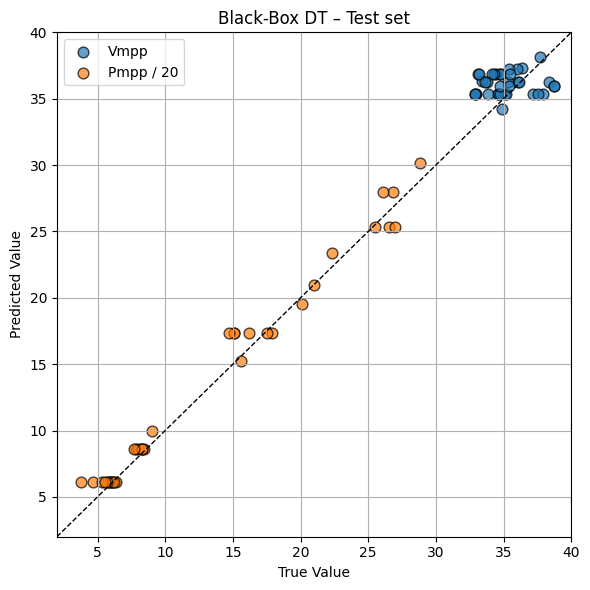

✅ 模型已保存为 dt_blackbox_vp.pkl


In [ ]:
# ================================================================
#  Black-Box Decision Tree  ——  Vmpp & Pmpp  (完整 y = x 虚线)
# ================================================================
!pip install -q scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, inspect, joblib, matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---------- 1. 读数据 ----------------------------------------------------
df = pd.read_csv('/content/pv_mpp_dataset_ext.csv')

# ---------- 2. 分组切分 ---------------------------------------------------
df['gid'] = (df['Ir']//100)*100 + ((df['T']+0.1)//5)*5
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(df, groups=df['gid']))
train_df, test_df = df.iloc[tr_idx], df.iloc[te_idx]

train_df = train_df.sample(frac=1, random_state=42)
val_cut  = int(0.8*len(train_df))
val_df   = train_df.iloc[val_cut:];  train_df = train_df.iloc[:val_cut]

print(f'Train {len(train_df)}  Val {len(val_df)}  Test {len(test_df)}')

# ---------- 3. 特征 / 标签 -----------------------------------------------
X_train, X_val, X_test = (train_df[['Ir','T']],
                          val_df  [['Ir','T']],
                          test_df [['Ir','T']])
y_train = train_df[['Vmpp','Pmpp']].values
y_val   = val_df  [['Vmpp','Pmpp']].values
y_test  = test_df [['Vmpp','Pmpp']].values

# ---------- 4. 训练 -------------------------------------------------------
dt = DecisionTreeRegressor(max_depth=4, random_state=0).fit(X_train, y_train)

# ---------- 5. 评估函数 (兼容旧 sklearn) ----------------------------------
def rmse_safe(a,b):
    sig = inspect.signature(mean_squared_error)
    return mean_squared_error(a,b, squared=False) if 'squared' in sig.parameters else \
           np.sqrt(mean_squared_error(a,b))

def eval_split(X, y, name):
    p = dt.predict(X)
    print(f'{name:<5}:  Vmpp RMSE={rmse_safe(y[:,0],p[:,0]):6.3f} V   '
          f'R²={r2_score(y[:,0],p[:,0]):6.3f} | '
          f'Pmpp RMSE={rmse_safe(y[:,1],p[:,1]):6.2f} W  '
          f'R²={r2_score(y[:,1],p[:,1]):6.3f}')
    return p
print('--- Decision Tree (Black-Box) 评估结果 ---')
pred_val  = eval_split(X_val,  y_val,  'VAL')
pred_test = eval_split(X_test, y_test, 'TEST')

# ---------- 6. 可视化 -----------------------------------------------------
plt.figure(figsize=(6,6))

# a) 散点
plt.scatter(y_test[:,0], pred_test[:,0],
            c='tab:blue',   label='Vmpp',   alpha=.7, edgecolors='k', s=60)
plt.scatter(y_test[:,1]/20, pred_test[:,1]/20,
            c='tab:orange', label='Pmpp / 20', alpha=.7, edgecolors='k', s=60)

# b) 取所有点(含缩放后功率)的全局 min / max
all_true = np.concatenate([y_test[:,0], y_test[:,1]/20])
all_pred = np.concatenate([pred_test[:,0], pred_test[:,1]/20])
lim_low  = np.floor( min(all_true.min(), all_pred.min()) ) - 1
lim_high = np.ceil(  max(all_true.max(), all_pred.max()) ) + 1

plt.plot([lim_low, lim_high], [lim_low, lim_high], 'k--', lw=1)   # 完整 y = x
plt.xlim(lim_low, lim_high);  plt.ylim(lim_low, lim_high)

plt.xlabel('True Value');  plt.ylabel('Predicted Value')
plt.title('Black-Box DT – Test set');  plt.legend();  plt.grid(True)
plt.tight_layout();  plt.show()

# ---------- 7. 保存模型 ---------------------------------------------------
joblib.dump(dt, '/content/dt_blackbox_vp.pkl')
print('✅ 模型已保存为 dt_blackbox_vp.pkl')



Train 122  Val 31  Test 36

🌟 最佳超参: {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_leaf': 1}
   5-折 CV  Vmpp  RMSE = 9.194 V

--- 调参后模型评估 ---
VAL  :  Vmpp RMSE =  1.272 V  R² =  0.186 | Pmpp RMSE =  11.63 W  R² =  0.993
TEST :  Vmpp RMSE =  1.757 V  R² = -0.113 | Pmpp RMSE =  13.19 W  R² =  0.993


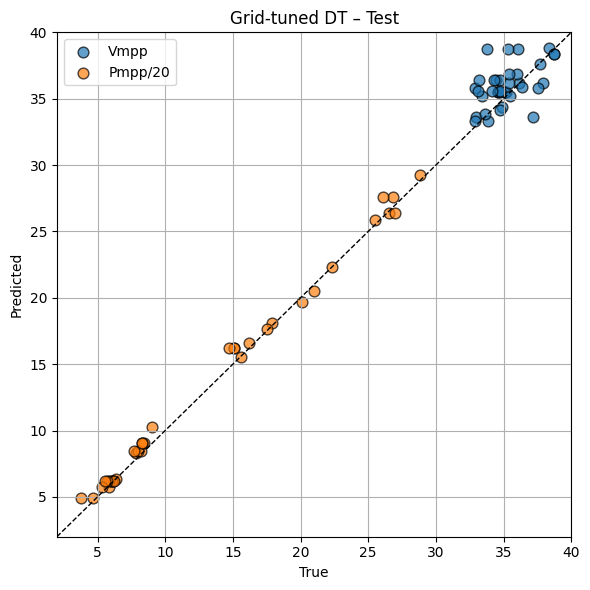


✅  最佳模型已保存为 dt_blackbox_vp_tuned.pkl


In [ ]:
# ================================================================
#  Black-Box DT (Vmpp & Pmpp)  +  GridSearchCV 超参调优
# ================================================================
!pip install -q scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt, inspect, joblib
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ---------- 1. 读数据 ----------------------------------------------------
df = pd.read_csv('/content/pv_mpp_dataset_ext.csv')   # 上传后路径

# ---------- 2. 分组切分 (防抖动泄漏) -------------------------------------
df['gid'] = (df['Ir']//100)*100 + ((df['T']+0.1)//5)*5
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(df, groups=df['gid']))
train_df, test_df = df.iloc[tr_idx], df.iloc[te_idx]

train_df = train_df.sample(frac=1, random_state=42)      # shuffle
val_cut  = int(0.8*len(train_df))
val_df   = train_df.iloc[val_cut:];  train_df = train_df.iloc[:val_cut]
print(f'Train {len(train_df)}  Val {len(val_df)}  Test {len(test_df)}')

# ---------- 3. 组装特征 / 标签 ------------------------------------------
X_train, X_val, X_test = (train_df[['Ir','T']],
                          val_df  [['Ir','T']],
                          test_df [['Ir','T']])
y_train = train_df[['Vmpp','Pmpp']].values
y_val   = val_df  [['Vmpp','Pmpp']].values
y_test  = test_df [['Vmpp','Pmpp']].values

# ---------- 4. 构建管道 & 网格 ------------------------------------------
pipe = make_pipeline(StandardScaler(),
                     DecisionTreeRegressor(random_state=0))

param_grid = {
    'decisiontreeregressor__max_depth':       [4,5,6,8,10],
    'decisiontreeregressor__min_samples_leaf':[1,2,4]
}

gkf = GroupKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid,
                    cv=gkf.split(X_train, y_train[:,0], groups=train_df['gid']),
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1, verbose=0)

grid.fit(X_train, y_train)

best_dt = grid.best_estimator_
print('\n🌟 最佳超参:', grid.best_params_)
print('   5-折 CV  Vmpp  RMSE = %.3f V' % (-grid.best_score_))

# ---------- 5. 评估函数 (兼容旧 sklearn) ----------------------------------
def rmse_safe(a,b):
    sig = inspect.signature(mean_squared_error)
    return mean_squared_error(a,b,squared=False) if 'squared' in sig.parameters \
           else np.sqrt(mean_squared_error(a,b))

def report(X, y, name):
    p = best_dt.predict(X)
    rv = rmse_safe(y[:,0], p[:,0]);   rp = rmse_safe(y[:,1], p[:,1])
    r2v = r2_score(y[:,0], p[:,0]);   r2p = r2_score(y[:,1], p[:,1])
    print(f'{name:<5}:  Vmpp RMSE = {rv:6.3f} V  R² = {r2v:6.3f} | '
          f'Pmpp RMSE = {rp:6.2f} W  R² = {r2p:6.3f}')
    return p

print('\n--- 调参后模型评估 ---')
pred_val  = report(X_val,  y_val,  'VAL')
pred_test = report(X_test, y_test, 'TEST')

# ---------- 6. 散点图 (完整对角线) ---------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test[:,0], pred_test[:,0], c='tab:blue',   label='Vmpp',   alpha=.7, edgecolors='k', s=60)
plt.scatter(y_test[:,1]/20, pred_test[:,1]/20,           c='tab:orange', label='Pmpp/20', alpha=.7, edgecolors='k', s=60)

all_true = np.concatenate([y_test[:,0], y_test[:,1]/20])
all_pred = np.concatenate([pred_test[:,0], pred_test[:,1]/20])
low, high = np.floor(min(all_true.min(), all_pred.min())-1), np.ceil(max(all_true.max(), all_pred.max())+1)
plt.plot([low, high], [low, high], 'k--', lw=1)
plt.xlim(low, high); plt.ylim(low, high)

plt.xlabel('True'); plt.ylabel('Predicted'); plt.title('Grid-tuned DT – Test')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------- 7. 保存最佳模型 ----------------------------------------------
joblib.dump(best_dt, '/content/dt_blackbox_vp_tuned.pkl')
print('\n✅  最佳模型已保存为 dt_blackbox_vp_tuned.pkl')


Train 124  Val 31  Test 34
🛠  Best params: {'decisiontreeregressor__max_depth': 8, 'decisiontreeregressor__min_samples_leaf': 2}

--- Grey-Box DT 评估 ---
VAL  :  Vmpp RMSE= 0.127 V  R²= 0.994 | Pmpp RMSE=  1.85 W  R²= 1.000
TEST :  Vmpp RMSE= 0.166 V  R²= 0.988 | Pmpp RMSE=  2.45 W  R²= 0.999


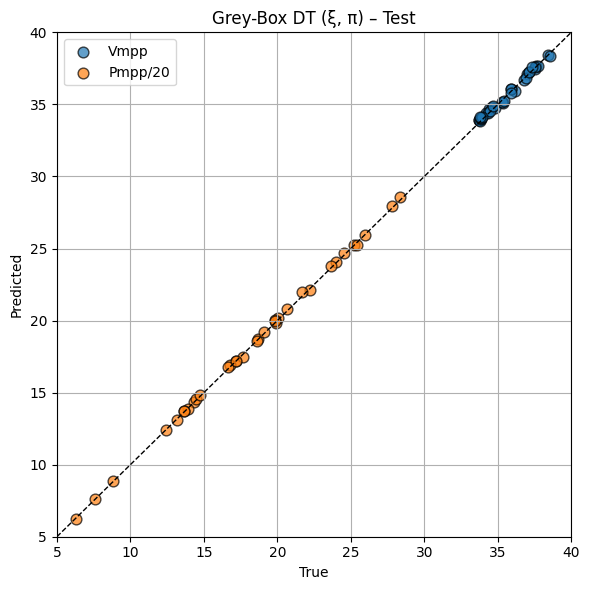


✅  灰盒模型已保存为 dt_greybox_xi_pi.pkl


In [ ]:
# ================================================================
#  Grey-Box Decision Tree  (ξ, π)  —— Vmpp & Pmpp 复原
#  依赖文件：pv_mpp_dataset_graybox.csv
# ================================================================
!pip install -q scikit-learn pandas numpy matplotlib

import pandas as pd, numpy as np, matplotlib.pyplot as plt, inspect, joblib
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# ---------- 1. 读取含 Voc, Isc, ξ, π 的灰盒数据 -------------------------
df = pd.read_csv('/content/pv_mpp_dataset_graybox.csv')

# ---------- 2. 分组切分：同一基准网格整组进入同一集合 -------------------
df['gid'] = (df['Ir']//100)*100 + ((df['T']+0.1)//5)*5
gss = GroupShuffleSplit(test_size=0.2, random_state=0)
tr_idx, te_idx = next(gss.split(df, groups=df['gid']))
train_df, test_df = df.iloc[tr_idx], df.iloc[te_idx]

train_df = train_df.sample(frac=1, random_state=0)      # shuffle
val_cut  = int(0.8 * len(train_df))
val_df   = train_df.iloc[val_cut:];  train_df = train_df.iloc[:val_cut]

print(f'Train {len(train_df)}  Val {len(val_df)}  Test {len(test_df)}')

# ---------- 3. 选择特征 / 标签 ------------------------------------------
#   方案 A：只用 (Ir,T) 作为输入  → 充分展示“灰盒先验”的效果
X_train, X_val, X_test = (train_df[['Ir','T']],
                          val_df  [['Ir','T']],
                          test_df [['Ir','T']])

y_train = train_df[['xi','pi']].values        # 标签 = 归一化 ξ, π
y_val   = val_df  [['xi','pi']].values
y_test  = test_df [['xi','pi']].values

# ---------- 4. 灰盒决策树 + 简易网格搜索调参 ----------------------------
pipe = make_pipeline(StandardScaler(),
                     DecisionTreeRegressor(random_state=0))
param_grid = {'decisiontreeregressor__max_depth':[4,5,6,8],
              'decisiontreeregressor__min_samples_leaf':[1,2,4]}
gkf  = GroupKFold(n_splits=5)
grid = GridSearchCV(pipe, param_grid,
                    cv=gkf.split(X_train, y_train[:,0], groups=train_df['gid']),
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1).fit(X_train, y_train)
best_dt = grid.best_estimator_
print('🛠  Best params:', grid.best_params_)

# ---------- 5. 评估函数 --------------------------------------------------
def rmse(a,b):
    sig = inspect.signature(mean_squared_error)
    return mean_squared_error(a,b,squared=False) if 'squared' in sig.parameters \
           else np.sqrt(mean_squared_error(a,b))

def evaluate(X, y, df_meta, tag):
    pred_norm = best_dt.predict(X)          # 预测 ξ̂, π̂
    Vm_hat = pred_norm[:,0] * df_meta['Voc'].values
    Pm_hat = pred_norm[:,1] * df_meta['Voc'].values * df_meta['Isc'].values
    Vm_true, Pm_true = df_meta['Vmpp'].values, df_meta['Pmpp'].values
    rv = rmse(Vm_true, Vm_hat); r2v = r2_score(Vm_true, Vm_hat)
    rp = rmse(Pm_true, Pm_hat); r2p = r2_score(Pm_true, Pm_hat)
    print(f'{tag:<5}:  Vmpp RMSE={rv:6.3f} V  R²={r2v:6.3f} | '
          f'Pmpp RMSE={rp:6.2f} W  R²={r2p:6.3f}')
    return Vm_hat, Pm_hat

print('\n--- Grey-Box DT 评估 ---')
_      = evaluate(X_val,  y_val,  val_df,  'VAL')
Vm_hat, Pm_hat = evaluate(X_test, y_test, test_df, 'TEST')

# ---------- 6. 散点图 ----------------------------------------------------
plt.figure(figsize=(6,6))
plt.scatter(test_df['Vmpp'], Vm_hat,
            c='tab:blue', label='Vmpp', alpha=.7, edgecolors='k', s=60)
plt.scatter(test_df['Pmpp']/20, Pm_hat/20,
            c='tab:orange', label='Pmpp/20', alpha=.7, edgecolors='k', s=60)

all_true = np.concatenate([test_df['Vmpp'], test_df['Pmpp']/20])
all_pred = np.concatenate([Vm_hat,          Pm_hat/20])
low, high = np.floor(min(all_true.min(), all_pred.min())-1), np.ceil(max(all_true.max(), all_pred.max())+1)
plt.plot([low, high], [low, high], 'k--', lw=1)
plt.xlim(low, high); plt.ylim(low, high)
plt.xlabel('True'); plt.ylabel('Predicted')
plt.title('Grey-Box DT (ξ, π) – Test'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------- 7. 保存模型 ---------------------------------------------------
joblib.dump(best_dt, '/content/dt_greybox_xi_pi.pkl')
print('\n✅  灰盒模型已保存为 dt_greybox_xi_pi.pkl')


**Vmpp** 残差直方图:

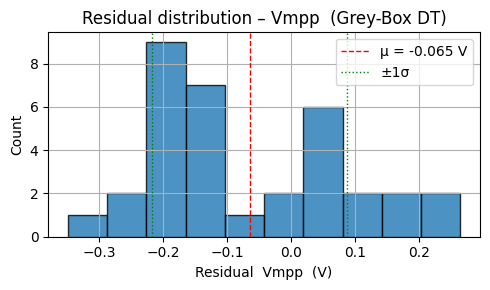

In [ ]:
# === Vmpp residual histogram (Test set) =========================
import matplotlib.pyplot as plt
import numpy as np

res_v = test_df['Vmpp'].values - Vm_hat      # 残差 = 真值 − 预测
mu, sigma = res_v.mean(), res_v.std()

plt.figure(figsize=(5,3))
plt.hist(res_v, bins=10, edgecolor='k', alpha=.8)
plt.axvline(mu,        color='r', ls='--', lw=1, label=f'μ = {mu:+.3f} V')
plt.axvline(mu+sigma,  color='g', ls=':',  lw=1, label='±1σ')
plt.axvline(mu-sigma,  color='g', ls=':',  lw=1)
plt.xlabel('Residual  Vmpp  (V)'); plt.ylabel('Count')
plt.title('Residual distribution – Vmpp  (Grey-Box DT)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


**学习曲线：**

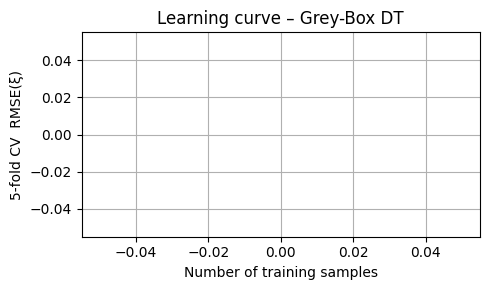

In [ ]:
# === Learning curve  (train size vs CV-RMSE of ξ) ===============
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, GroupKFold
from sklearn.metrics import make_scorer, mean_squared_error

def rmse(y_true, y_pred):                              # 自定义 RMSE scorer
    return mean_squared_error(y_true, y_pred, squared=False)

gkf = GroupKFold(n_splits=5)
train_sizes, _, val_scores = learning_curve(
    best_dt, X_train, y_train[:,0],                    # 只用 ξ 列评估
    train_sizes=np.linspace(0.2,1.0,6),
    cv=gkf.split(X_train, y_train[:,0], groups=train_df['gid']),
    scoring=make_scorer(rmse, greater_is_better=False),
    n_jobs=-1, shuffle=True, random_state=0)

rmse_val = -val_scores.mean(axis=1)                    # 取均值并变正

plt.figure(figsize=(5,3))
plt.plot(train_sizes, rmse_val, 'o-')
plt.xlabel('Number of training samples')
plt.ylabel('5-fold CV  RMSE(ξ)')
plt.title('Learning curve – Grey-Box DT')
plt.grid(True); plt.tight_layout(); plt.show()


**特征重要度条形图：**

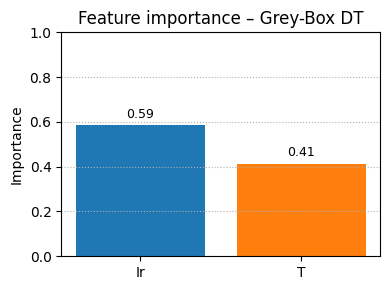

In [ ]:
# === Feature importance (Ir vs T) ================================
import matplotlib.pyplot as plt
import numpy as np

dt_core = best_dt.named_steps['decisiontreeregressor']  # 取管道中的 DT
imp = dt_core.feature_importances_

plt.figure(figsize=(4,3))
bars = plt.bar(['Ir','T'], imp, color=['tab:blue','tab:orange'])
plt.ylabel('Importance'); plt.ylim(0,1)
plt.title('Feature importance – Grey-Box DT')
for b,val in zip(bars, imp):
    plt.text(b.get_x()+b.get_width()/2, val+0.02, f'{val:.2f}',
             ha='center', va='bottom', fontsize=9)
plt.grid(axis='y', ls=':')
plt.tight_layout(); plt.show()
